# Creating the labeled dataset

Let's now gather our votes from the labeling tool and transform that into a labeled dataset consisting of privacy practices (sentences) and a class. We wanna end up having something like:

| id | sentence                                                                                                                                     | label          |
|----|----------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| 1  | You should be aware that resumes may be monitored by your current employer                                                                   | very_dangerous |
| 2  | If you have sent or posted content on the Service, We may not be able to delete it.                                                          | dangerous      |
| 3  | We will only provide those companies the information they need to deliver the service.                                                       | neutral        |
| 4  | The personal information we have access to varies by website and is controlled by your privacy settings on that website and by your consent. | friendly       |
| 5  | We are committed to protecting your personal information and maintaining your trust.                                                         | very_friendly  |

With labels:
```
0: very_friendly
1: friendly
2: neutral
3: dangerous
4: very_dangerous
```

## Getting our votes from the server

We're using a Rails server for the labeling tool.

So, just log in to the server, do `rails c` and then:

```
f = File.new("votes.csv", "w")
f << Vote.all.to_csv
f.close
```

And then, to copy the file from the remote server, we use `scp`:

`scp rails@146.185.142.138:/home/rails/apps/ethicalprivacy/current/votes.csv ~/GitHub/guard/data`

In [72]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [2]:
votes = pd.read_csv("data/votes.csv")

In [3]:
votes[:3]

,id,sentence_1,sentence_2,winner_sentence,user_id,created_at,updated_at
0,1,13991,47721,47721,NaN,2019-05-04 13:15:57 UTC,2019-05-04 13:15:57 UTC
1,2,59638,82254,59638,NaN,2019-05-04 13:16:44 UTC,2019-05-04 13:16:44 UTC
2,3,61907,86793,61907,NaN,2019-05-04 14:36:51 UTC,2019-05-04 14:36:51 UTC


## Importing the rest of the data

We're also gonna need our sentences dataset to a) build our confrontation matrix and b) know which sentences IDs in our votes dataset correspond to which sentences.

In [4]:
sentences = pd.read_csv("data/sentences_corpus.csv", index_col=0)

In [5]:
sentences[:3]

,policy_id,text
0,0,Privacy Policy Last mo...
1,0,"When you share information with us, for exampl..."
2,0,"As you use our services, we want you to be cle..."


## Building the confrontation matrix 

So we know there are `len(sentences)` sentences in our dataset. And thus, we need to build a matrix of such dimensions

In [6]:
conf_matrix = np.zeros([len(sentences),len(sentences)])

In [7]:
conf_matrix.shape

(115813, 115813)

In [8]:
conf_matrix[1234][1234]

0.0

Now our strategy is gonna be: go vote by vote and access the position `[sentence_1 - 1, sentence_2 -1]` (note the `-1` because the `Vote` model exported from Rails starts counting `Sentences` at 1 and not at 0 like Pandas, so we need to account for that).

For each accessed position, if the winner is `sentence_1`, add a 1. If not, substract 1.

In [9]:
for index, row in votes.iterrows():
    row_pos = int(row['sentence_1']) - 1
    col_pos = int(row['sentence_2']) -1
    matrix_position = conf_matrix[row_pos][col_pos]
    if(row['winner_sentence'] == row['sentence_1']):
        matrix_position += 1
    else:
        matrix_position -= 1
    # Now just save to the "db", our confrontation matrix
    conf_matrix[row_pos][col_pos] = matrix_position

In [10]:
conf_matrix[13990][47720]

-1.0

## From confrontation matrix to absolute scores

Now we have our confrontation matrix ready. Let's compute the net score for each sentence (i.e.: let's calculate the sum per row)

But first, since doing such calculation for a matrix this huge is very computationally expensive, we need to know which Vote IDs are unique and do the calculation only for those ones.

In [22]:
# We use the union of sets, which by definition can only contain unique values, and then cast that back into a list
# Source: http://code.activestate.com/recipes/580634-merge-unique-items-from-multiple-lists-into-a-new-/
vote_1_uniques = votes.sentence_1.unique()
vote_2_uniques = votes.sentence_2.unique()
vote_ids = list(set().union(vote_1_uniques, vote_2_uniques))
vote_ids[:5]

[104576, 75649, 86793, 68491, 26381]

In [79]:
sentences_cols = ["sentence_id", "score"]
sentences_scores = pd.DataFrame(columns = sentences_cols)
sentences_scores

for id in vote_ids:
    matrix_position = id - 1
    score = int(np.sum(conf_matrix[matrix_position]))
    sentences_scores = sentences_scores.append(pd.Series([
            id,
            score
            ],
            index = sentences_cols), 
         ignore_index = True)
    
sentences_scores[:10]

,sentence_id,score
0,104576,1
1,75649,0
2,86793,0
3,68491,0
4,26381,-1
5,97428,0
6,115224,0
7,1437,0
8,61859,1
9,52004,0


## From absolute scores to labels

Let's now see the frequency distribution of our votes

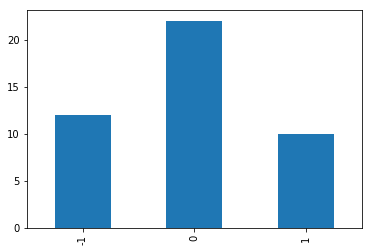

In [80]:
fig, ax = plt.subplots()
sentences_scores.score.value_counts().sort_index(ascending=True).plot(ax=ax, kind='bar')

Ideally, we want our dataset to be normally distributed.

Our strategy in a couple of cells is gonna be to plot a normal distributed version of our dataset and set cut points on some concrete percentiles, which will result in our labels.

### Normalize the scores

In [85]:
x = sentences_scores[['score']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)

In [89]:
sentences_scores["score_normalized"] = df_normalized[0]
sentences_scores[:10]

,sentence_id,score,score_normalized
0,104576,1,1.0
1,75649,0,0.5
2,86793,0,0.5
3,68491,0,0.5
4,26381,-1,0.0
5,97428,0,0.5
6,115224,0,0.5
7,1437,0,0.5
8,61859,1,1.0
9,52004,0,0.5


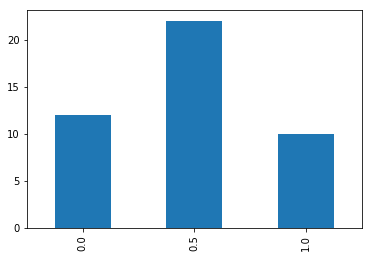

In [90]:
fig, ax = plt.subplots()
sentences_scores.score_normalized.value_counts().sort_index(ascending=True).plot(ax=ax, kind='bar')

### Apply labels to normally distributed data

We now have all our scores in range [0, 1] What we're gonna do now is set percentiles to determine our labels, according to the following table:

| percentile | label          |
|------------|----------------|
| 0.05       | very_dangerous |
| 0.2        | dangerous      |
| rest       | neutral        |
| 0.8        | friendly       |
| 0.95       | very_friendly  |

In [100]:
labels = []

for index, row in sentences_scores.iterrows():
    score = row['score_normalized']
    if( score <= 0.05 ):
        label = "very_dangerous"
    elif ( score > 0.5 and score <= 0.2):
        label = "dangerous"
    elif ( score > 0.2 and score <= 0.8 ):
        label = "neutral"
    elif ( score > 0.8 and score <= 0.95 ):
        label = "friendly"
    elif ( score > 0.95 ):
        label = "very_friendly"
    else:
        label = "unknown"
        
    labels.append(label)

In [101]:
sentences_scores["label"] = labels
sentences_scores[:10]

,sentence_id,score,score_normalized,labels,label
0,104576,1,1.0,very_friendly,very_friendly
1,75649,0,0.5,neutral,neutral
2,86793,0,0.5,neutral,neutral
3,68491,0,0.5,neutral,neutral
4,26381,-1,0.0,very_dangerous,very_dangerous
5,97428,0,0.5,neutral,neutral
6,115224,0,0.5,neutral,neutral
7,1437,0,0.5,neutral,neutral
8,61859,1,1.0,very_friendly,very_friendly
9,52004,0,0.5,neutral,neutral


## From labels to our labeled training dataset

We're almost ready. We now have our labels, let's build a proper training dataset we can later use to train our neural network and save it as Pickle and .csv for convenience.

In [107]:
labeled_sentences_cols = ["sentence", "label"]
labeled_sentences = pd.DataFrame(columns = labeled_sentences_cols)
labeled_sentences

for index, row in sentences_scores.iterrows():
    sentence_id = row['sentence_id'] - 1
    sentence = sentences.iloc[sentence_id].text
    label = row['label']
    
    labeled_sentences = labeled_sentences.append(pd.Series([
            sentence,
            label
            ],
            index = labeled_sentences_cols), 
         ignore_index = True)
    
labeled_sentences[:10]

,sentence,label
0,California Residents How Do You Access and Upd...,very_friendly
1,Invitation recipients have the right to revoke...,neutral
2,If the person is under the legal age to enter ...,neutral
3,Clienteling: Customers who have a one-to-one r...,neutral
4,100% complete security does not presently exis...,very_dangerous
5,We do NOT provide your Location data for adver...,neutral
6,"For example, we use a combination of firewalls...",neutral
7,"Finally, we never use or share the personally ...",neutral
8,This Notice of Privacy Practices explains: Th...,very_friendly
9,Inquiries may be forwarded to the appropriate ...,neutral


In [116]:
labeled_sentences.describe()

,sentence,label
count,44,44
unique,44,3
top,Nonaffiliates we share with can include financ...,neutral
freq,1,22


In [117]:
labeled_sentences.to_pickle("data/labeled_sentences_corpus.pkl")

In [118]:
labeled_sentences.to_csv("data/labeled_sentences_corpus.csv")